In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings('ignore')  # 忽略无关警告
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示异常


In [2]:
# 1. 数据加载与预处理
data_all = pd.read_excel("问卷结果_1205.xlsx", sheet_name="Sheet1")
data_all['年级'] =data_all.apply(
    lambda row: '本科低年级' if row['您的年级是'] <= 2 
    else'本科高年级' if row['您的年级是'] <= 4 
    else'研一' if row['您的年级是'] == 5 
    else'研二及以上' if row['您的年级是'] <= 8 
    else '其他',
    axis=1
)
data = data_all[data_all['您是否观看过微短剧']==1]
data_0 = data_all[data_all['您是否观看过微短剧']==2]
# 定义各维度题项
# S维度（刺激）
S_cols = {
    'S1-平台特性刺激': ['请根据您的实际感受选择符合的选项—微短剧平台推送的内容很符合我的兴趣','微短剧平台操作方便、播放流畅',
                  '微短剧平台的弹幕、评论等互动功能很活跃','微短剧单部更新快、上新数量多',], 
    'S2-内容特性刺激': ['微短剧剧情反转多、“爽点”密集', '大部分微短剧的剧情和套路都比较相似','微短剧的演员表现、画面质量等制作水平高','微短剧的题材新颖、符合我的喜好'],        
    'S3-营销策略刺激': ['微短剧广告解锁的时长(如30秒、1分钟)在我可接受范围内', '微短剧单集价格或者周月卡价格在我可接受范围内','微短剧平台的促销活动(如折扣、满减)很有吸引力','我常在社交媒体上看到微短剧相关的热门内容'],
    'S4-社交刺激': ['同学、朋友经常推荐我观看微短剧', '我所在的社交平台群里常讨论微短剧'],
}
# O维度（有机体）
O_cols = {
    'O1-社会影响': ['当朋友、同学、网红等都在看微短剧，我也愿意去看'],      
    'O2-绩效期望（享乐）': ['请根据您的心理感受与认知选择符合的选项 —观看微短剧能满足我的休闲娱乐需求', '观看微短剧能让我感到愉悦、有“爽”感'],    
    'O3-习惯': ['我已经形成固定的微短剧观看习惯(如每天睡前、课间必看)', '当我需要娱乐时，我习惯性地自动打开微短剧观看'],    
    'O4-便利条件': ['观看微短剧需要的设备、时间、网络我都能满足', '学业压力大、时间紧张会减少我观看微短剧的频率','微短剧的“碎片化”时长(2-3分钟)刚好适配我的空闲时间(如课间、通勤)' ],   
    'O5-价格价值': ['微短剧带来的体验值得我观看广告进行剧集解锁', '微短剧带来的体验值得我付费进行剧集解锁'],  
}
# R维度（反应）
R_cols = {
    'R1-观看意愿': ['您计划未来继续观看微短剧的意愿程度'],      
    'R2-广告解锁意愿': ['您未来愿意通过观看广告解锁短剧的可能性'],          
    'R3-付费意愿': ['您未来愿意为微短剧(如单集解锁、会员购买)付费的可能性']  
}

#负向进行正向调整
cols = ['微短剧平台推送的内容不能吸引我','大部分微短剧的剧情和套路都比较相似','学业压力大、时间紧张会减少我观看微短剧的频率']
for col in cols:
    data[col] = 6 - data[col].copy()
# 计算各维度均值
for dim, cols in {**S_cols, **O_cols, **R_cols}.items():
    data[dim + "_均值"] = data[cols].fillna(data[cols].mean(axis=1)).mean(axis=1)

# 2. 观看依赖度分组
data['依赖度分组'] = data.apply(
    lambda row: '高依赖' 
    if (row['您观看微短剧的频率大致为'] <= 3 and row['您平均每周观看微短剧的时长约为'] >= 3) 
    else '低依赖',
    axis=1
)
dependence_dist = data['依赖度分组'].value_counts().sort_index()
print(f"\n看短剧人群依赖度分组分布：")
for group, count in dependence_dist.items():
    print(f"{group}：{count}人（{count/len(data)*100:.1f}%）")


看短剧人群依赖度分组分布：
低依赖：342人（70.4%）
高依赖：144人（29.6%）


S/O/R各维度方差分析结果：
                维度      F值      P值 是否显著  低依赖均值  高依赖均值  高依赖-低依赖差值
0     S1-平台特性刺激_均值   5.343  0.0212    是  3.735  3.910      0.174
1     S2-内容特性刺激_均值  20.689  0.0000    是  3.292  3.531      0.239
2     S3-营销策略刺激_均值  10.395  0.0013    是  3.658  3.931      0.273
3       S4-社交刺激_均值  15.279  0.0001    是  3.503  3.917      0.414
4       O1-社会影响_均值   1.267  0.2609    否  3.632  3.764      0.132
5   O2-绩效期望（享乐）_均值   6.876  0.0090    是  3.825  4.042      0.217
6         O3-习惯_均值  16.929  0.0000    是  3.512  3.951      0.440
7       O4-便利条件_均值   0.229  0.6328    否  3.253  3.278      0.024
8       O5-价格价值_均值   8.271  0.0042    是  3.605  3.903      0.298
9       R1-观看意愿_均值  21.660  0.0000    是  3.602  4.097      0.495
10    R2-广告解锁意愿_均值   2.351  0.1259    否  3.690  3.861      0.171
11      R3-付费意愿_均值   9.923  0.0017    是  3.561  3.931      0.369


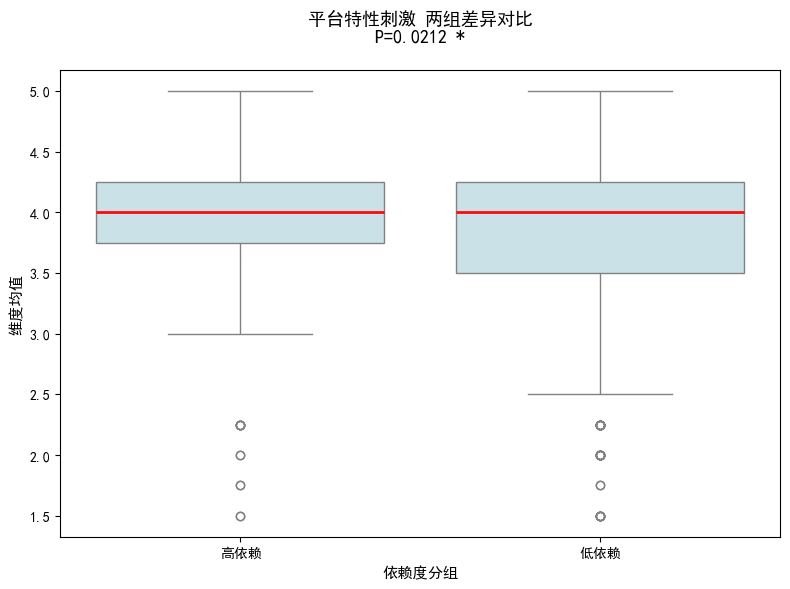

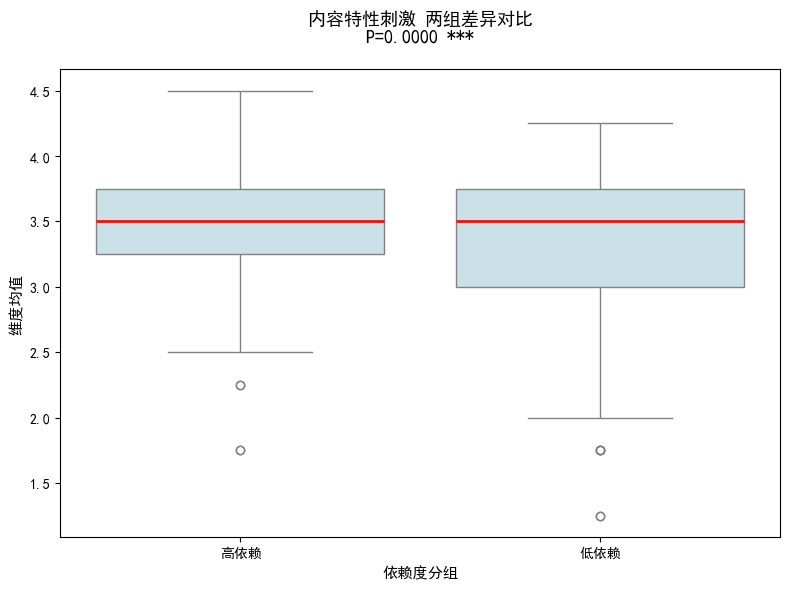

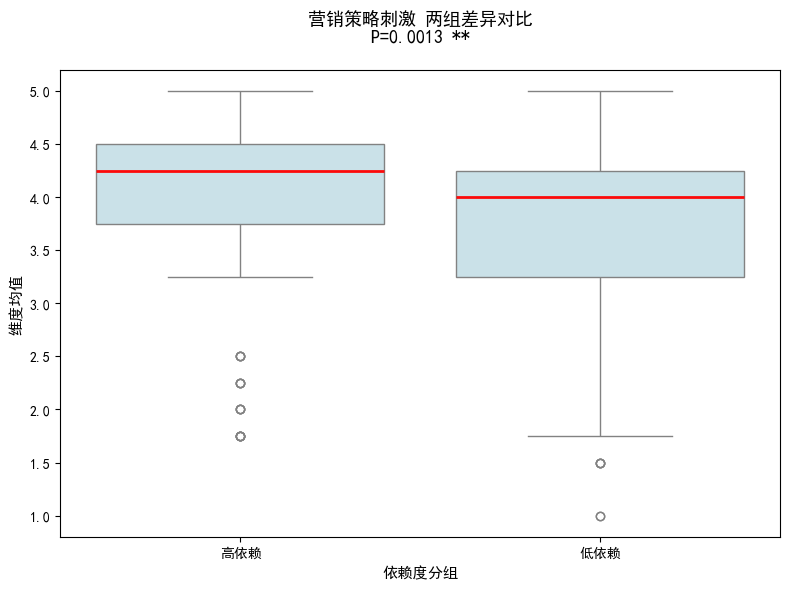

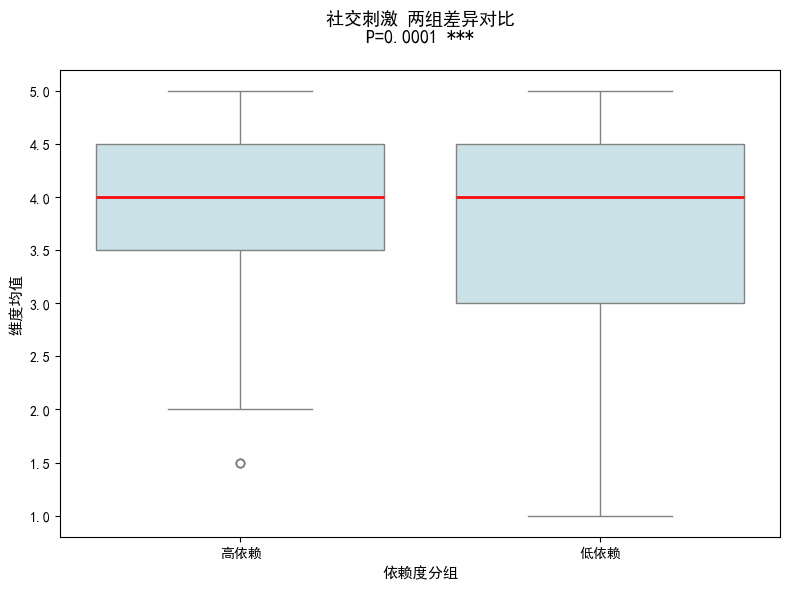

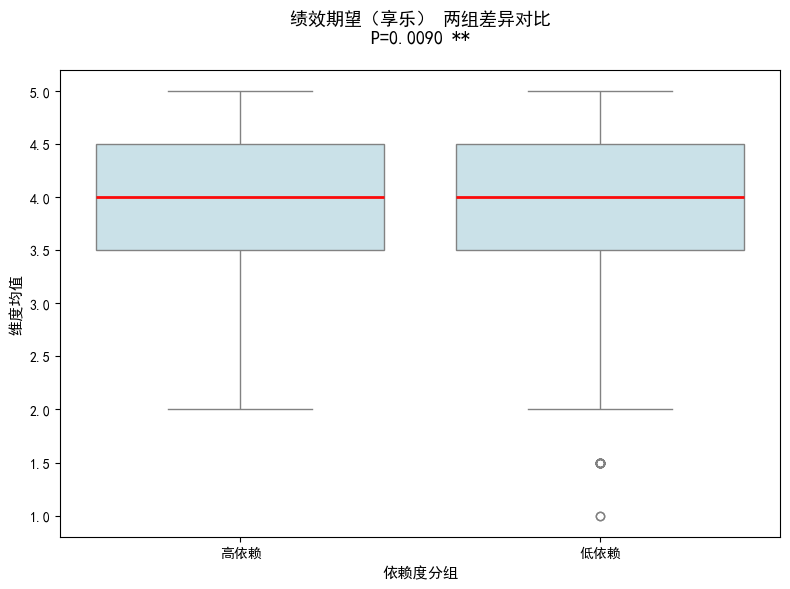

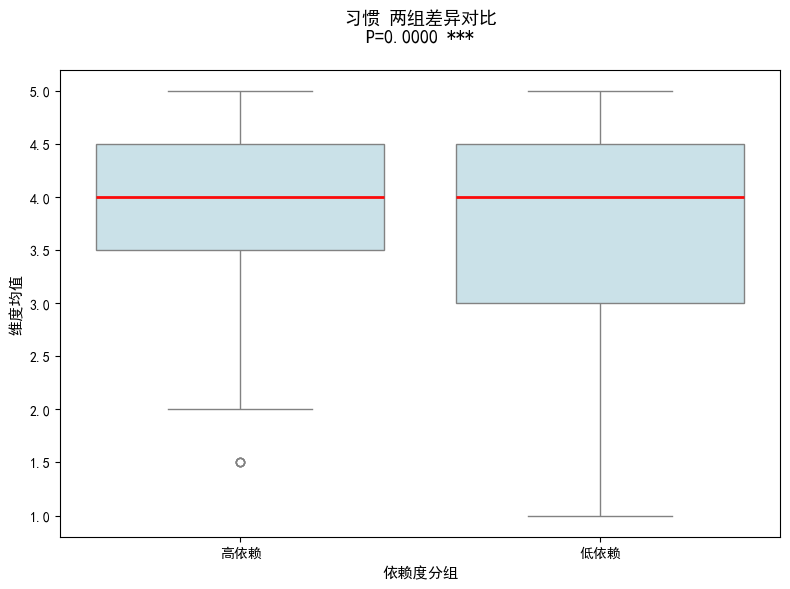

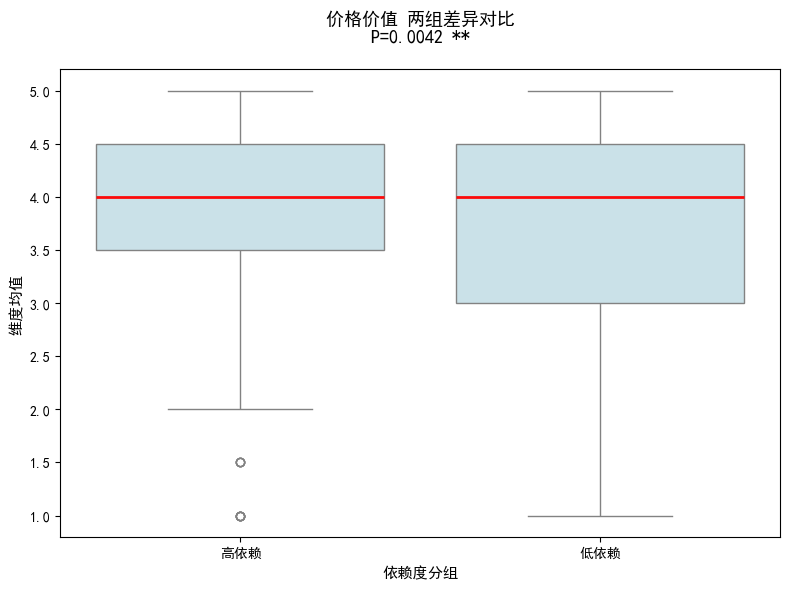

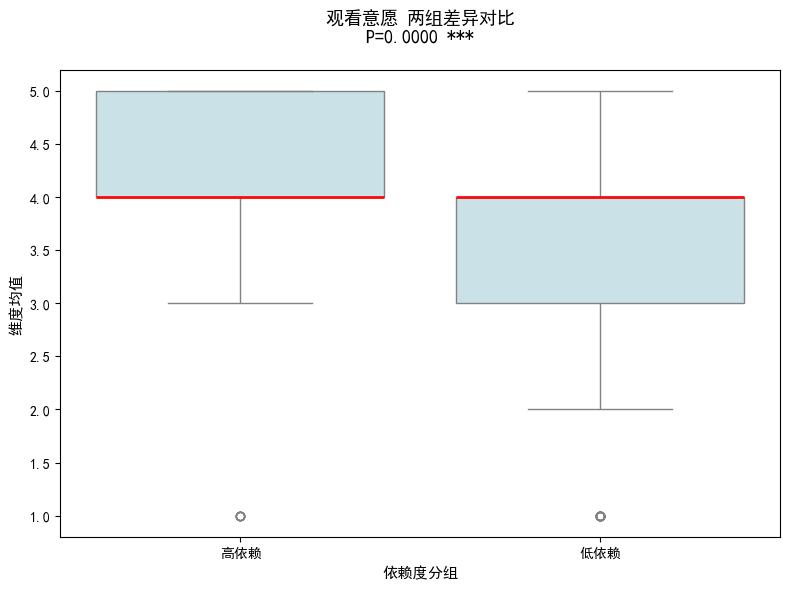

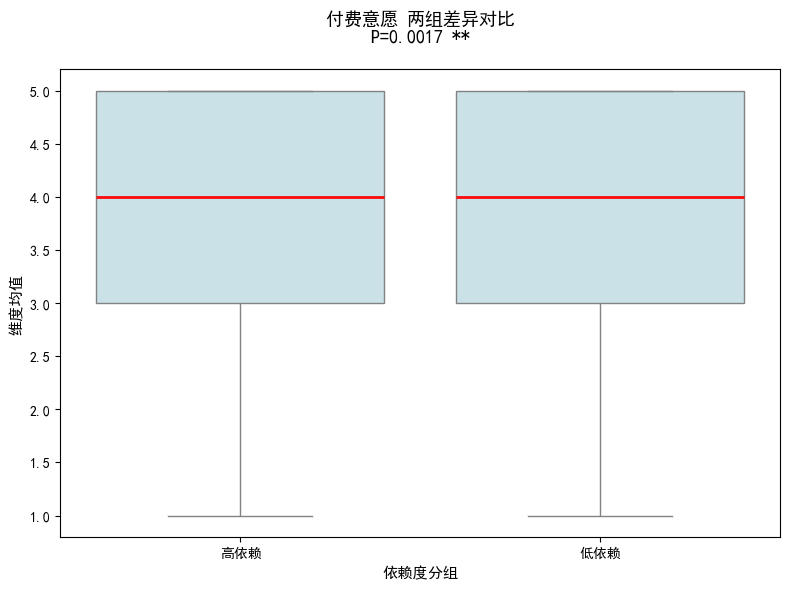

In [3]:
# 3. 方差分析
def anova_analysis(data, group_col, dim_cols):
    """
    对指定维度列进行单因素方差分析（仅适用于两组数据），并计算两组均值差值
    
    参数：
    data: DataFrame - 原始数据
    group_col: str - 分组列名（仅包含两个不同分组）
    dim_cols: list - 需要分析的维度列名列表
    
    返回：
    DataFrame - 包含维度、F值、P值、是否显著、均值差值的分析结果
    """
    results = []
    # 获取两个分组名称
    group_names = sorted(data[group_col].unique())
    
    for dim in dim_cols:
        # 1. 按组别拆分数据
        group1_data = data[data[group_col] == group_names[0]][dim].dropna()
        group2_data = data[data[group_col] == group_names[1]][dim].dropna()
        
        # 2. 执行单因素方差分析
        f_val, p_val = f_oneway(group1_data, group2_data)
        
        # 3. 计算两组均值差值
        mean1 = group1_data.mean()
        mean2 = group2_data.mean()
        mean_diff = round(mean2 - mean1, 3)
        
        # 4. 整理结果
        results.append({
            "维度": dim,
            "F值": round(f_val, 3),
            "P值": round(p_val, 4),
            "是否显著": "是" if p_val < 0.05 else "否",
            f"{group_names[0]}均值": round(mean1, 3),  
            f"{group_names[1]}均值": round(mean2, 3),  
            f"{group_names[1]}-{group_names[0]}差值": mean_diff  # 均值差值
        })
    
    return pd.DataFrame(results)

# 执行方差分析
dim_mean_cols = [col for col in data.columns if col.endswith("_均值")]
anova_result = anova_analysis(data,'依赖度分组',dim_mean_cols)
print("S/O/R各维度方差分析结果：")
print(anova_result)

# 筛选显著维度
sig_dims = anova_result[anova_result["是否显著"] == "是"]["维度"].tolist()

# 维度名称简化映射
dim_simplify = {
    'S1-平台特性刺激_均值': '平台特性刺激',
    'S2-内容特性刺激_均值': '内容特性刺激',
    'S3-营销策略刺激_均值': '营销策略刺激',
    'S4-社交刺激_均值': '社交刺激',
    'O2-绩效期望（享乐）_均值': '绩效期望（享乐）',
    'O3-习惯_均值': '习惯',
    'O5-价格价值_均值': '价格价值',
    'R1-观看意愿_均值': '观看意愿',
    'R3-付费意愿_均值': '付费意愿'
}

# 确保简化名称全覆盖
sig_dims_simple = [dim_simplify.get(dim, dim) for dim in sig_dims]

# 循环为每个显著维度单独绘制并保存图片
if sig_dims:
    for i, (dim, dim_simple) in enumerate(zip(sig_dims, sig_dims_simple)):
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # 绘制箱线图（
        colors = ['#C5E3ED', '#C5E3ED']  # 高低依赖组固定配色
        median_color = '#FC0A0A'  # 中位数线颜色
        sns.boxplot(
            x="依赖度分组", 
            y=dim, 
            data=data, 
            ax=ax, 
            palette=colors, 
            medianprops={'color': median_color, 'linewidth': 2}
        )
        
        # 获取P值并设置显著性标记
        p_val = anova_result[anova_result['维度'] == dim]['P值'].iloc[0]
        if p_val < 0.001:
            sig_mark = '***'
        elif p_val < 0.01:
            sig_mark = '**'
        elif p_val < 0.05:
            sig_mark = '*'
        else:
            sig_mark = ''
        
        # 设置标题和坐标轴标签
        ax.set_title(
            f'{dim_simple} 两组差异对比\nP={p_val:.4f} {sig_mark}',
            fontsize=13, fontweight='bold', pad=20
        )
        ax.set_xlabel('依赖度分组', fontsize=11)
        ax.set_ylabel('维度均值', fontsize=11)
        ax.tick_params(labelsize=10)
        
        # 调整布局并保存单个图片
        plt.tight_layout()
        safe_filename = f"依赖度分组_{dim_simple}_差异箱线图.png".replace('/', '_').replace('（', '(').replace('）', ')')
        plt.savefig(
            safe_filename, 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='white'
        )
        plt.show()
        plt.close(fig)  # 关闭画布，释放内存

In [4]:
#4. 群体需求痛点分析
zero_view_data = data_0.copy().reset_index(drop=True)

obstacle_cols = [col for col in zero_view_data.columns if col.startswith("21")]  # 阻碍因素列
ad_will_cols = [col for col in data.columns if col.startswith("16")]            # 广告解锁原因列
pay_will_cols = [col for col in data.columns if col.startswith("19")]           # 付费解锁原因列
play_cols = [col for col in zero_view_data.columns if col.startswith("22")]     # 娱乐方式列

def get_top_indicators(df, indicator_name, indicator_cols, top_n=5, name_prefix=""):
    """
    统计指标频数并获取Top N指标
    :param df: 数据框
    :param indicator_name: 指标名称（如“阻碍因素”）
    :param indicator_cols: 指标列列表
    :param top_n: 取前N个指标
    :param name_prefix: 指标列名前缀（用于去除）
    :return: Top N指标名称列表、Top N指标列名列表、完整频数统计
    """
    indicator_freq = pd.DataFrame({
        indicator_name: [col.replace(name_prefix, "") for col in indicator_cols],
        "人数": [df[col].sum() for col in indicator_cols],
        "占比(%)": [round(df[col].sum() / len(df) * 100, 2) for col in indicator_cols]
    }).sort_values("人数", ascending=False)
    
    top_indicators = indicator_freq.head(top_n)[indicator_name].tolist()
    top_indicator_cols = [f"{name_prefix}{ind}" for ind in top_indicators]
    
    return top_indicators, top_indicator_cols, indicator_freq

#阻碍因素分析
print("===== 阻碍因素统计 =====")
top5_obstacles, top5_obstacle_cols, obstacle_freq = get_top_indicators(
    df=zero_view_data,
    indicator_name="阻碍因素",
    indicator_cols=obstacle_cols,
    top_n=5,
    name_prefix="21"
)
print(obstacle_freq)

# 广告解锁原因分析
print("\n===== 广告解锁原因统计 =====")
if ad_will_cols:
    top5_ad_will, top5_ad_will_cols, ad_will_freq = get_top_indicators(
        df=data,
        indicator_name="广告解锁原因",
        indicator_cols=ad_will_cols,
        top_n=5,
        name_prefix="16"
    )
    print(ad_will_freq)
    
# 付费解锁原因分析
print("\n===== 付费解锁原因统计 =====")
if pay_will_cols:
    top5_pay_will, top5_pay_will_cols, pay_will_freq = get_top_indicators(
        df=data,
        indicator_name="付费解锁原因",
        indicator_cols=pay_will_cols,
        top_n=5,
        name_prefix="19"
    )
    print(pay_will_freq)

# 娱乐方式分析
print("\n===== 娱乐方式统计 =====")
if play_cols:
    top8_play, top8_play_cols, play_freq = get_top_indicators(
        df=zero_view_data,
        indicator_name="娱乐方式",
        indicator_cols=play_cols,
        top_n=8,
        name_prefix="22"
    )
    print(play_freq)

===== 阻碍因素统计 =====
           阻碍因素    人数  占比(%)
0  没兴趣，不喜欢该类型内容  92.0   92.0
3    觉得广告太多，体验差  72.0   72.0
2    觉得剧情低俗/套路化  64.0   64.0
1         没时间观看  32.0   32.0
4   不知道有哪些微短剧平台   8.0    8.0
5            其他   0.0    0.0

===== 广告解锁原因统计 =====
       广告解锁原因     人数  占比(%)
0        节省开支  298.0  61.32
3     广告内容不反感  228.0  46.91
1     广告时长可接受  198.0  40.74
2  仅偶尔观看，无需付费  168.0  34.57
4          其他    2.0   0.41

===== 付费解锁原因统计 =====
              付费解锁原因     人数  占比(%)
3  会员权益丰富(如免广告+专属内容)  254.0  52.26
2         内容质量高，愿意支持  148.0  30.45
1          想快速解锁全部内容  144.0  29.63
0              不想看广告  118.0  24.28
4                 其他   36.0   7.41

===== 娱乐方式统计 =====
                      娱乐方式    人数  占比(%)
1        短视频（抖音、快手，不包括微短剧）  72.0   72.0
4            阅读（小说、漫画、公众号）  56.0   56.0
3         社交软件（如微信、小红书、微博）  38.0   38.0
0  长视频（如腾讯视频、爱奇艺、Bilibili）  36.0   36.0
2           手机游戏（如王者荣耀、原神）  24.0   24.0
5                   听音乐/播客  24.0   24.0
6                  户外活动/运动  24.0   24.0
7               